# ISS-VSE CA1

In [1]:
import os
import random as rand
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import imgaug as ia
from imgaug import augmenters as iaa

from CA1_Yolo import *
from voc import *
import xml.etree.ElementTree as ET
from keras.utils import Sequence

### Read all image and VOC dataset

In [2]:
def read_annotation_files(image_dir, annnotation_dir):
    all_annotations = []
    labels = {}
    for anno in sorted(os.listdir(annnotation_dir)):
        img = {'object':[]}
        try:
            xml_tree = ET.parse(annnotation_dir + anno)
        except Exception as ex:
            print(ex)
            print(f'Error parsing annotation xml: {annnotation_dir + anno}')
            continue
        for elem in xml_tree.iter():
            if 'filename' in elem.tag:
                img['filename'] = image_dir + elem.text
            if 'width' in elem.tag:
                img['width'] = int(elem.text)
            if 'height' in elem.tag:
                img['height'] = int(elem.text)
            if 'object' in elem.tag:
                obj = {}
                for attribute in list(elem):
                    if 'name' in attribute.tag:
                        obj['name'] = attribute.text
                        if obj['name'] in labels:
                            labels[obj['name']] += 1
                        else:
                            labels[obj['name']] = 1
                        img['object'] += [obj]
                    if 'bndbox' in attribute.tag:
                        for dim in list(attribute):
                            if 'xmin' in dim.tag:
                                obj['xmin'] = int(round(float(dim.text)))
                            if 'ymin' in dim.tag:
                                obj['ymin'] = int(round(float(dim.text)))
                            if 'xmax' in dim.tag:
                                obj['xmax'] = int(round(float(dim.text)))
                            if 'ymax' in dim.tag:
                                obj['ymax'] = int(round(float(dim.text)))
        if len(img['object']) > 0:
            bb_list = []
            for obj in img['object']:
                bb_list.append(ia.BoundingBox(x1=obj['xmin'], y1=obj['ymin'], x2=obj['xmax'], y2=obj['ymax'], label=obj['name']))
            img['bbs'] = ia.BoundingBoxesOnImage(bb_list, shape=(img['width'], img['height']))
            all_annotations += [img]
    return all_annotations, labels

In [3]:
#Reference https://www.kaggle.com/mpalermo/keras-pipeline-custom-generator-imgaug
class DataGenerator(Sequence):
    '''Generate data with augmentations using Keras Util Sequence API
        Required Methods:
        def __init__(self)
        def __len__(self)
        def on_epoch_end(self)
        def __getitem__(self)'''

    def __init__(self, image_path, labels, anchors, batch_size=32, image_dims=(416, 416, 3), shuffle=False, augment=True):
        self.image_path=image_path
        self.labels=labels
        self.anchors=anchors
        self.batch_size=batch_size
        self.image_dims=image_dims
        self.shuffle=shuffle
        self.augment=augment

        self.on_epoch_end()
    
    def __len__(self):
        return int(np.floor(len(self.image_path)/self.batch_size))
    
    def on_epoch_end(self):
        '''Update index after each epoch'''
        self.index = np.arange(len(self.image_path))
        if self.shuffle:
            np.random.shuffle(self.index)
    
    def augment_with_bb(self, images, boundingbox):
        seq = iaa.Sequential([
            iaa.AdditiveGaussianNoise(scale=0.05*255),
            iaa.Affine(translate_px={"x": (1, 5)})
        ])
        return seq(images=images, bounding_boxes=boundingbox)
    
    def __getitems__(self, index):
        pass

In [4]:
trainimgfolder = "../data/image/"
trainannotatefolder = "../data/annotation/"
train_ints, labels = read_annotation_files(trainimgfolder, trainannotatefolder)
labels_unqiue = labels.keys()

In [8]:
labels

{'car': 313}

In [9]:
# seq = iaa.Sequential([
#     iaa.Multiply((1.2, 1.5)), # change brightness, doesn't affect BBs
#     iaa.Affine(
#         translate_px={"x": 40, "y": 60},
#         scale=(0.5, 0.7)
#     ) # translate by 40/60px on x/y axis, and scale to 50-70%, affects BBs
# ])

seq = iaa.Sequential([
    iaa.AdditiveGaussianNoise(scale=0.05*255),
    iaa.Affine(translate_px={"x": (1, 5)})
])

In [10]:
# imgs = [] 
# imgs.append(cv2.imread(train_ints[0]['filename']))
# imgs.append(cv2.imread(train_ints[1]['filename']))
img = cv2.imread(train_ints[0]['filename'])
img_aug, bbs_aug = seq(image=img, bounding_boxes=train_ints[0]['bbs'])

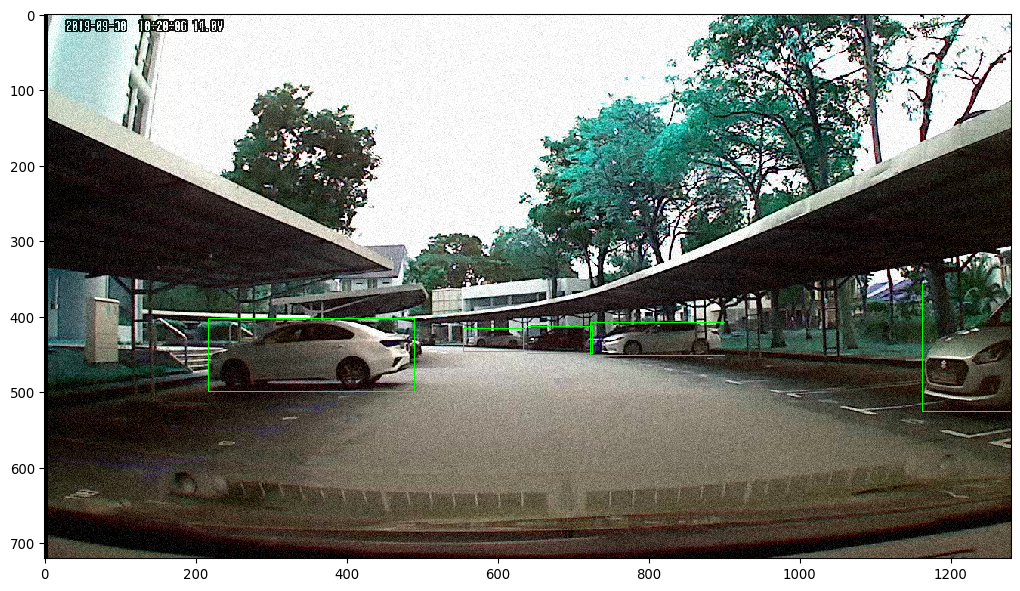

In [11]:
ia.imshow(bbs_aug.draw_on_image(img_aug))


In [12]:
# class BoundingBox:
#     '''Bounding Box definition'''
#     def __init__(self, xmin, ymin, xmax, ymax, c = None, classes = None):
#         self.xmin=xmin
#         self.ymin=ymin
#         self.xmax=xmax
#         self.ymax=ymax
#         self.c=c
#         self.classes=classes
#         self.label = None
#         self.score = None
#     def get_label(self):
#         if self.label == None:
#             self.label = np.argmax(self.classes)
#         return self.label
#     def get_score(self):
#         if self.score == None:
#             self.score = self.classes[self.get_label()]
#         return self.score
# def interval_overlap(interval_a, interval_b):
#     x1, x2 = interval_a
#     x3, x4 = interval_b
    
#     if x3 < x1:
#         if x4 < x1:
#             return 0
#         else:
#             return min(x2, x4) - x1
#     else:
#         if x2 < x3:
#             return 0
#         else:
#             return min(x2, x4) - x3

# def boundbox_iou(bx1, bx2):
#     intsec_w = interval_overlap([bx1.xmin, bx2.xmax], [bx2.xmin, bx2.xmax])
#     intsec_h = interval_overlap([bx1.ymin, bx2.ymax], [bx2.ymin, bx2.ymax])
#     intsec = intsec_w * intsec_h
#     w1, h1 = bx1.xmax-bx1.xmin, bx1.ymax-bx1.ymin
#     w2, h2 = bx2.xmax-bx2.xmin, bx2.ymax-bx2.ymin
#     union = w1*h1 + w2*h2 - intsec
#     return float(intsec)/union

In [13]:
bbs_aug.bounding_boxes

[BoundingBox(x1=217.0000, y1=403.0000, x2=490.0000, y2=499.0000, label=car),
 BoundingBox(x1=555.0000, y1=416.0000, x2=634.0000, y2=446.0000, label=car),
 BoundingBox(x1=639.0000, y1=413.0000, x2=726.0000, y2=449.0000, label=car),
 BoundingBox(x1=723.0000, y1=408.0000, x2=901.0000, y2=451.0000, label=car),
 BoundingBox(x1=1162.0000, y1=357.0000, x2=1285.0000, y2=526.0000, label=car)]

In [14]:
bbs_aug.bounding_boxes[1].label

'car'

In [15]:
labels = ['car', 'bus']
labels.index(bbs_aug.bounding_boxes[1].label)

0

In [16]:
iou = bbs_aug.bounding_boxes[0].iou(bbs_aug.bounding_boxes[1])
print(iou)

0.0


In [17]:
anchors = fulltest
anchors

NameError: name 'fulltest' is not defined

In [18]:
for i in range(len(anchors)//2):
    print(str(anchors[2*i]) + ', ' + str(anchors[2*i+1]))

NameError: name 'anchors' is not defined

In [19]:
for b in bbs_aug.bounding_boxes:
    print(b.x1)

217.0
555.0
639.0
723.0
1162.0


In [20]:
an1 = ia.BoundingBox(x1=0.0,y1=0.0,x2=anchors[0][0],y2=anchors[0][1])
bb1 = ia.BoundingBox(x1=0.0,y1=0.0,x2=bbs_aug.bounding_boxes[0].x2,y2=bbs_aug.bounding_boxes[0].y2)
ioutest = bb1.iou(an1)
ioutest

NameError: name 'anchors' is not defined

In [21]:
bb = bbs_aug.bounding_boxes[1]
bb.x1

555.0

In [22]:
for bb in bbs_aug.bounding_boxes:
    max_anchor = None
    max_index = -1
    max_iou = -1
    for i in range(len(anchors)):
        ach = anchors[i]
        iou = bb.iou(ach)

NameError: name 'anchors' is not defined

In [23]:
def calculate_iou(anno, centroids):
    anno_width, anno_height = anno
    iou_list = []
    anno_area = anno_width * anno_height
    for cent in centroids:
        cent_width, cent_height = cent
        if cent_width <= anno_width and cent_height >= anno_height:
            iou = cent_width * anno_height / (anno_area + cent_width * (cent_height - anno_height))
        elif cent_width >= anno_width and cent_height >= anno_height:
            iou = anno_area / (cent_width * cent_height)
        elif cent_width >= anno_width and cent_height <= anno_height:
            iou = anno_width * cent_height / (anno_area + (cent_width - anno_width) * cent_height)
        else:
            iou = (cent_width * cent_height) / anno_area
        iou_list.append(iou)
    return np.array(iou_list)

In [47]:
annotations_dim = []
num_anchors = 9
for anno in train_ints:
    for obj in anno['object']:
        rel_width = (float(obj['xmax']) - float(obj['xmin'])) / anno['width']
        rel_height = (float(obj['ymax']) - float(obj['ymin'])) / anno['height']
        annotations_dim.append(tuple(map(float,(rel_width, rel_height))))


anno_arr = np.array(annotations_dim)
curr_assign_centroids = np.zeros(anno_arr.shape[0])
curr_distances = np.zeros((anno_arr.shape[0], num_anchors))

In [48]:
len(annotations_dim)

313

In [49]:
indexes = [rand.randrange(anno_arr.shape[0]) for anchor in range(num_anchors)]
sample_centroids = anno_arr[indexes]
final = sample_centroids.copy()
iterations = 0
while True:
    iterations += 1
    distances = []
    for idx in range(anno_arr.shape[0]):
        distance = 1 - calculate_iou(anno_arr[idx], sample_centroids)
        distances.append(distance)
    distances_arr = np.array(distances)
    print(f'iter: {iterations} distances: {np.sum(np.abs(curr_distances-distances_arr))}')
    assign_centroids = np.argmin(distances_arr, axis=1)
    if (assign_centroids == curr_assign_centroids).all():
        final = sample_centroids
        break
    centroid_sums = np.zeros((num_anchors, anno_arr.shape[1]), np.float)
    for idx in range(anno_arr.shape[0]):
        centroid_sums[assign_centroids[idx]] += anno_arr[idx]
    for idx in range(num_anchors):
        sample_centroids[idx] = centroid_sums[idx] / (np.sum(assign_centroids==idx) + 1e-6)
    curr_assign_centroids = assign_centroids.copy()
    curr_distances = distances_arr.copy()

iter: 1 distances: 1691.614564988183
iter: 2 distances: 149.8143447733426
iter: 3 distances: 99.06210831752185
iter: 4 distances: 54.939707712018944
iter: 5 distances: 28.267375323266805
iter: 6 distances: 27.157324543080534
iter: 7 distances: 14.718716683914682
iter: 8 distances: 4.2871725090203565
iter: 9 distances: 9.574612990449994
iter: 10 distances: 13.512372318148287
iter: 11 distances: 11.030946678316848
iter: 12 distances: 5.73689642890411
iter: 13 distances: 6.421779101023673
iter: 14 distances: 4.77363906129532


In [26]:
def print_anchors(centroids):
    out_string = ''

    anchors = centroids.copy()

    widths = anchors[:, 0]
    sorted_indices = np.argsort(widths)

    r = "anchors: ["
    for i in sorted_indices:
        out_string += str(int(anchors[i,0]*416)) + ',' + str(int(anchors[i,1]*416)) + ', '
            
    print(out_string[:-2])
print_anchors(final)

29,20, 35,53, 42,29, 53,93, 63,45, 82,124, 87,68, 109,91, 114,36


In [50]:
test = final
# test
test = test[test[:,0].argsort()]
test

array([[0.06968246, 0.05026882],
       [0.07284007, 0.12083333],
       [0.1002907 , 0.06812015],
       [0.11904633, 0.16072796],
       [0.1391276 , 0.26591434],
       [0.14340277, 0.10003086],
       [0.21913422, 0.1787796 ],
       [0.22310267, 0.10932539],
       [0.25080914, 0.26339285]])

In [51]:
fulltest=[]
for t in test:
    fulltest.append(((int(t[0]*416)),(int(t[1]*416))))

In [52]:
fulltest

[(28, 20),
 (30, 50),
 (41, 28),
 (49, 66),
 (57, 110),
 (59, 41),
 (91, 74),
 (92, 45),
 (104, 109)]

In [30]:
def read_voc(xml_file: str):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    list_with_all_boxes = []
    for boxes in root.iter('object'):
        filename = root.find('filename').text
        ymin, xmin, ymax, xmax = None, None, None, None
        for box in boxes.findall("bndbox"):
            ymin = int(box.find("ymin").text)
            xmin = int(box.find("xmin").text)
            ymax = int(box.find("ymax").text)
            xmax = int(box.find("xmax").text)
        list_with_single_boxes = [xmin, ymin, xmax, ymax]
        list_with_all_boxes.append(list_with_single_boxes)
    return filename, list_with_all_boxes

In [31]:
# trainimgfolder = 'D:\\Workspace\\GitHub\\keras-yolo3\\data\\old_annotated_416x416\\'
# trainannotatefolder = 'D:\\Workspace\\GitHub\\keras-yolo3\\data\\old_raw_416x416\\'
trainimgfolder = "../data/image/"
trainannotatefolder = "../data/annotation/"
cache = 'D:\Workspace\GitHub\ISS-VSE-2019-09-23-IS1FT-CA1\data\cached'
labels = ['car','bus']
train_ints, train_labels = parse_voc_annotation(trainannotatefolder, trainimgfolder, cache, labels)

In [32]:
max_box_per_image = max([len(inst['object']) for inst in (train_ints)])
max_box_per_image

6

In [33]:
ann = os.listdir(trainannotatefolder)
ann[0]

'b001.xml'

In [34]:
tree = ET.parse(trainannotatefolder+ann[4])

In [35]:
tree

In [36]:
seen_labels = {}
img = {'object':[]}
for elem in tree.iter():
    if 'filename' in elem.tag:
        img['filename'] = trainimgfolder + elem.text
    if 'width' in elem.tag:
        img['width'] = int(elem.text)
    if 'height' in elem.tag:
        img['height'] = int(elem.text)
    if 'object' in elem.tag or 'part' in elem.tag:
        obj = {}

        for attr in list(elem):
            if 'name' in attr.tag:
                obj['name'] = attr.text

                if obj['name'] in seen_labels:
                    seen_labels[obj['name']] += 1
                else:
                    seen_labels[obj['name']] = 1

                if len(labels) > 0 and obj['name'] not in labels:
                    break
                else:
                    img['object'] += [obj]

            if 'bndbox' in attr.tag:
                for dim in list(attr):
                    if 'xmin' in dim.tag:
                        obj['xmin'] = int(round(float(dim.text)))
                    if 'ymin' in dim.tag:
                        obj['ymin'] = int(round(float(dim.text)))
                    if 'xmax' in dim.tag:
                        obj['xmax'] = int(round(float(dim.text)))
                    if 'ymax' in dim.tag:
                        obj['ymax'] = int(round(float(dim.text)))

In [37]:
seen_labels

{'car': 5}

In [38]:
img

{'object': [{'name': 'car',
   'xmin': 109,
   'ymin': 399,
   'xmax': 448,
   'ymax': 524},
  {'name': 'car', 'xmin': 561, 'ymin': 418, 'xmax': 647, 'ymax': 443},
  {'name': 'car', 'xmin': 650, 'ymin': 417, 'xmax': 743, 'ymax': 448},
  {'name': 'car', 'xmin': 769, 'ymin': 405, 'xmax': 943, 'ymax': 473},
  {'name': 'car', 'xmin': 435, 'ymin': 405, 'xmax': 499, 'ymax': 477}],
 'filename': '../data/image/b005.jpg',
 'width': 1280,
 'height': 720}

In [39]:
TESt = img.copy()

In [40]:
TESt += [img]

TypeError: unsupported operand type(s) for +=: 'dict' and 'list'

In [41]:
allinst = []
allinst += [img]
allinst += [img]

In [42]:
allinst

[{'object': [{'name': 'car',
    'xmin': 109,
    'ymin': 399,
    'xmax': 448,
    'ymax': 524},
   {'name': 'car', 'xmin': 561, 'ymin': 418, 'xmax': 647, 'ymax': 443},
   {'name': 'car', 'xmin': 650, 'ymin': 417, 'xmax': 743, 'ymax': 448},
   {'name': 'car', 'xmin': 769, 'ymin': 405, 'xmax': 943, 'ymax': 473},
   {'name': 'car', 'xmin': 435, 'ymin': 405, 'xmax': 499, 'ymax': 477}],
  'filename': '../data/image/b005.jpg',
  'width': 1280,
  'height': 720},
 {'object': [{'name': 'car',
    'xmin': 109,
    'ymin': 399,
    'xmax': 448,
    'ymax': 524},
   {'name': 'car', 'xmin': 561, 'ymin': 418, 'xmax': 647, 'ymax': 443},
   {'name': 'car', 'xmin': 650, 'ymin': 417, 'xmax': 743, 'ymax': 448},
   {'name': 'car', 'xmin': 769, 'ymin': 405, 'xmax': 943, 'ymax': 473},
   {'name': 'car', 'xmin': 435, 'ymin': 405, 'xmax': 499, 'ymax': 477}],
  'filename': '../data/image/b005.jpg',
  'width': 1280,
  'height': 720}]